# AUDiaL: Evaluation Report

This notebook outlines the evaluation methodology of [AUDiaL](https://github.com/tomurillo/AUDiaL) (<strong>A</strong>ccessible <strong>U</strong>niversal <strong>Dia</strong>grams through <strong>L</strong>anguage), a Web prototype of a Natural Language Interface (NLI) to diagrams aiming to ease the access to statistical charts to the visually impaired population.

Let us first load the required Python dependencies and utility methods:

In [1]:
from IPython.display import display, Markdown
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 6]

# Thresholds
alpha_norm = 0.05

def analyze_data(measure, start=1, combine_first=False):
    """
    Read the indicated columns from eval_data and return statistics about them
    @param measure: string; name of dataset header to consider, without trailing index
    @param start: int; header index to start from (default: 1)
    @param combine_first: bool; whether the first two headers need to be combined into a single column (default: False)
    @return means, stds, maxs, mins, x_combine, m_combine: arrays with statistics of the given measures
    """
    means, stds, maxs, mins, x_combine, m_combine = [], [], [], [], [], []
    i = start - 1
    while True:
        try:
            i += 1
            if combine_first and i == 1:
                continue
            measures = eval_data[:]['{}__{}'.format(measure, i)]
            if combine_first and i == 2:
                measures = np.add(measures, eval_data[:]['{}__1'.format(measure)])  # Combine Task 1 and Task 2
            measures = measures[np.where(measures > -1)[0]]  # Missing values are set to -1; skip them
            x_combine.extend([i-1 for _ in range(len(measures))])
            m_combine.extend(measures)
            means.append(measures.mean())
            stds.append(measures.std())
            maxs.append(measures.max())
            mins.append(measures.min())
        except ValueError:
            break
    return means, stds, maxs, mins, x_combine, m_combine

## Evaluation Questions

AUDiaL is a Web-based prototype of a NLI to statistical diagrams, such as bar charts. It was designed and implemented in order to test a number of research questions:
<ol>
    <li>Is natural language a sufficient means for non-visual autonomous access to diagrams for blind persons?</li>
    <li>Can visualization semantics encoded via ontologies be efficiently retrieved via a Natural Language Interface (NLI)?</li>
    <li>How should a NLI be adapted for the specific needs of blind persons reading diagrams?</li>
</ol>

In order to answer these questions, AUDiaL was employed in a number of evaluation sessions with blind participants. In each session, participants were asked to solve tasks of increasing difficulty using both AUDiaL and their preferred means of accessing diagrams. Qualitative and quantitative measures of the efficacy of AUDiaL in comparison with traditional alternative diagram versions were gathered from analyzing several measures of how participants solved these tasks. 

## Method

In [2]:
CSV_DIR = 'data'
DEMO_FILE = 'AUDiaL_evaluation_anonymized.csv'
eval_data = np.genfromtxt(os.path.join(CSV_DIR, DEMO_FILE), dtype=None, delimiter=',', names=True, encoding=None)
N = eval_data.shape[0]
print('N={} participants.'.format(N))

N=9 participants.


## Effectiveness

In order to assess the success rate of the perfomed tasks, we measure task solving effectiveness. Effectiveness is measured by grading each answer to a task (or lack thereof) with the following scale:

<ul>
    <li>Task completed with ease: 0</li>
    <li>Task partially completed or completed with difficulty: 1</li>
    <li>Task failed: 2</li>
</ul>

Success or failure of tasks was determined by the experimenter, whereas the subjective difficulty of tasks was communicated by the participants by answering the following feedback question after answering each task:


<section>
    <h5>Were you able to complete the task?:</h5>
    <ol>
        <li>Yes, with ease</li>
        <li>Yes, but with diffculty</li>
        <li>I am not sure</li>
        <li>No, I failed to complete the task</li>
    </ol>
<section>
    
If a participant failed to complete the task, a score of 2 was assigned to the answer regardless of their subjective impression of whether they had been able to solve it. If the participant answered the task in a partial manner, a score of 1 was also given regardless of the feedback given. If the task was answered correctly, then a score of 0 was assigned to the answer if the participant chose "Yes, with ease"  to the feedback question; otherwise, the answer was given a score of 1.

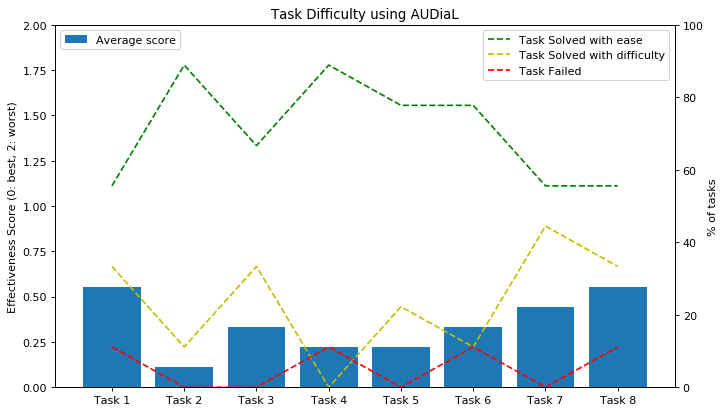

In [20]:
# Collect statistics
eff_means, eff_stds, eff_maxs, eff_mins, eff_x_comb, eff_comb = analyze_data('Dialogue__Efficiency')
# Count samples on each task
tasks, tasks_count = np.unique(np.array(eff_x_comb), return_counts=True)
# % of failed tasks
failed_counts = np.zeros((len(eff_means),), dtype=int)
failed_idx = np.where(np.array(eff_comb) == 2)
failed, f_count = np.unique(np.array(eff_x_comb)[failed_idx], return_counts=True)
failed_counts[failed] = f_count
failed_p = failed_counts*100/tasks_count
# % of tasks solved with difficulty
solved_diff_counts = np.zeros((len(eff_means),), dtype=int)
solved_diff_idx = np.where(np.array(eff_comb) == 1)
solved_diff, sd_count= np.unique(np.array(eff_x_comb)[solved_diff_idx], return_counts=True)
solved_diff_counts[solved_diff] = sd_count
solved_diff_p = solved_diff_counts*100/tasks_count
# % of tasks solved with ease
solved_ease_p = 100 - failed_p - solved_diff_p
# Horizontal axis values (zero-indexed)
x = np.arange(len(eff_means))
# Plot means
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.set_ylim([0, 2])
ax1.bar(x, eff_means, label='Average score')
ax1.set_ylabel('Effectiveness Score (0: best, 2: worst)')
ax1.legend(loc='upper left')
# Plot unsuccessful tasks
ax2 = ax1.twinx()
ax2.set_ylim([0,100])
ax2.set_ylabel('% of tasks')
plt.plot(x, solved_ease_p, linestyle='--', color='g', label='Task Solved with ease')
plt.plot(x, solved_diff_p, linestyle='--', color='y', label='Task Solved with difficulty')
plt.plot(x, failed_p, linestyle='--', color='r',label='Task Failed')
ax2.legend(loc='upper right')
# Rest of plot
xticks = ['Task {}'.format(i) for i in range(1, len(eff_means)+1)]
plt.xticks(x, xticks)
plt.title('Task Difficulty using AUDiaL')
plt.show()

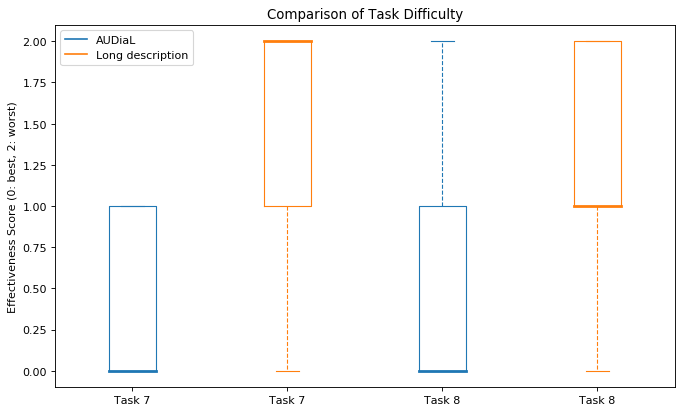

In [4]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color, linestyle='--')
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color, linewidth=2.5)

#  Collect statistics for last two tasks in both modalities
start = len(eff_means)-1
eff_table_means, eff_table_stds, eff_table_maxs, eff_table_mins, eff_table_x_comb, eff_table_comb = \
    analyze_data('Table__Efficiency', start=start)
#  Plot all
fig = plt.figure(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
task_idx = np.unique(np.array(eff_table_x_comb))
ticks = []
scores = [[], []]
scores_d, scores_t = [], []  # Combined scores of both tasks
i = 0
for task_i in task_idx:
    s_d = np.array(eff_comb)[np.where(np.array(eff_x_comb) == task_i)]
    scores[i].append(s_d)
    scores_d.extend(s_d)
    s_t = np.array(eff_table_comb)[np.where(np.array(eff_table_x_comb) == task_i)]
    scores[i].append(s_t)
    scores_t.extend(s_t)
    ticks.append('Task {}'.format(task_i + 1))
    i += 1
scores = np.array(scores)
labels = ['AUDiaL', 'Long description']
colors = ['#1F77B4', '#FF7F0E']
for i in range(len(scores)):
    pos = np.array(range(i, len(scores[0])*len(scores), len(scores)))
    bp = plt.boxplot(scores[:, i].T, positions=pos)
    set_box_color(bp, colors[i])
    plt.plot([], c=colors[i], label=labels[i])
plt.xticks(range(len(scores)*len(scores[0])), np.repeat(ticks, len(scores)))
plt.xlim(-0.5, len(scores)*len(scores[0])-0.5)
plt.ylabel('Effectiveness Score (0: best, 2: worst)')
plt.title('Comparison of Task Difficulty')
plt.legend()
plt.show()

Next, let us perform a Chi-Square test of independece in order to test the significance of the difference in effectiveness. This will allow us to answer the question: <i>is employing AUDiaL more efficient than traditional table-based access methods when solving complex tasks on diagrams?</i>. The following statistical hypothesis is defined:

* <strong>Null Hypothesis (H0)</strong> $ \mu_0=\mu_1 $: Task solving effectiveness is the same regardless of the method employed i.e. there is no relation between the method used (independent variable) and effectiveness measured through the effectiveness score (dependent variable)
* <strong>Alternative Hypothesis (H1)</strong> $ \mu_0 \neg \mu_1 $: Task solving effectiveness is higher when employing AUDiaL as opposed to traditional table-based methods i.e. there is a relation between the method used (independent variable) and effectiveness measured through the effectiveness score (dependent variable)

In [5]:
alpha = .05
unique_d, counts_d = np.unique(scores_d, return_counts=True)
unique_t, counts_t = np.unique(scores_t, return_counts=True)
chi2, p_val, _, _ = stats.chi2_contingency([counts_d, counts_t])
print("chi_square={:06.4f}; p={:06.4f}".format(chi2, p_val))
if p_val < alpha:
    print("Null Hypothesis rejected (p < {:04.2f}).".format(alpha))
    hyp_decision = 'reject'
    hyp_sig = 'significant'
else:
    print("Null Hypothesis accepted (p >= {:04.2f}).".format(alpha))
    hyp_decision = 'accept'
    hyp_sig = 'not significant'
hyp_txt = 'With $ p={:06.4f} $ and $ \chi^{{2}}={:06.4f} $, we can {} the Null Hypothesis of independence. '
hyp_txt += 'Therefore, we can conclude that the difference in effectiveness in using both methods is {}.'
display(Markdown(hyp_txt.format(p_val, chi2, hyp_decision, hyp_sig)))

chi_square=9.3048; p=0.0095
Null Hypothesis rejected (p < 0.05).


With $ p=0.0095 $ and $ \chi^{2}=9.3048 $, we can reject the Null Hypothesis of independence. Therefore, we can conclude that the difference in effectiveness in using both methods is significant.

## Efficiency

Efficiency was measured by observing how long it took participants to complete those tasks that were given at least a partially correct answer. Time was kept via the implemented system logs of AUDiaL, and by manually measuring it in the case of table-based tasks. Manual timekeeping is not as accurate as system log timestamps are, thus they are rounded to the nearest minute.

Because both the answers for *Task 1* and *Task 2* could be fetched from the diagram's summary, most participants required a very short time to complete *Task 2*. For this reasons, the times of *Task 1* and *Task 2* have been combined into a single timestamp in the following analysis.

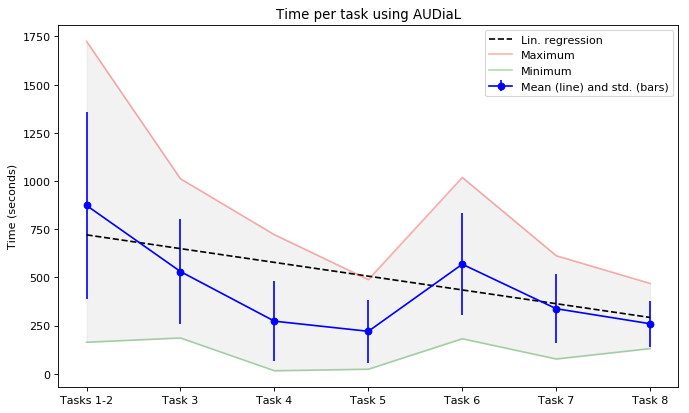

In [6]:
# Collect statistics
t_means, t_stds, t_maxs, t_mins, t_x_comb, t_comb = analyze_data('Dialogue__Time', combine_first=True)

# Horizontal axis values (zero-indexed)
x = np.arange(len(t_means))

# Linear regression of datapoints
linfit = np.polyfit(t_x_comb, t_comb, 1)
linfit_fn = np.poly1d(linfit)

# Plot all
xticks = ['Tasks 1-2']
xticks.extend(['Task {}'.format(j) for j in range(3, len(t_means) + 2)])
fig = plt.figure(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(x, t_means, t_stds, linestyle='-', marker='o', color='b', label='Mean (line) and std. (bars)')
plt.plot(x, linfit_fn(x), '--k', label='Lin. regression')
plt.plot(x, t_maxs, color='r', alpha=.3, label='Maximum')
plt.fill_between(x, t_mins, t_maxs, color='silver', alpha=.2)
plt.plot(x, t_mins, color='g', alpha=.3, label='Minimum')
plt.xticks(x, xticks)
plt.ylabel('Time (seconds)')
plt.title('Time per task using AUDiaL')
plt.legend(loc='upper right')
plt.show()

From the plot above, the following conclusions can be derived:
<ul>
    <li>As shown by the linear regression fitting line, time per task decreases with time as participants got used to the Web prototype. This fact is exacerbated if we consider that latter tasks are harder to asnwer than the previous ones.</li>
    <li>Tasks 1 and 2 took users the longest to solve, as participants spent a long time reading the summary and exploring the diagrams.</li>
</ul>

Next, the difference in efficiency for the two hardest tasks will be studied:

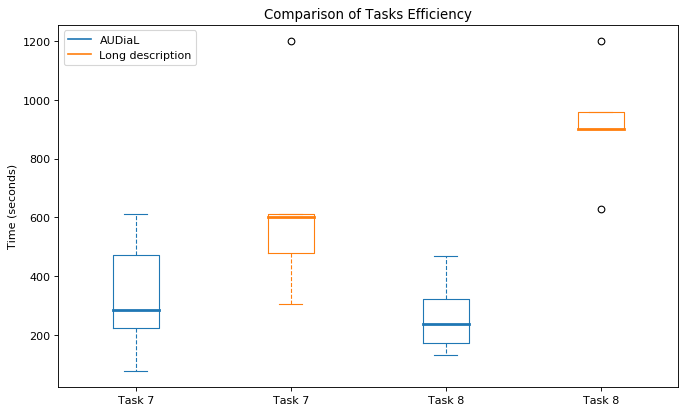

In [7]:
#  Collect statistics for last two tasks in both modalities
start = len(t_means)
t_table_means, t_table_stds, t_table_maxs, t_table_mins, t_table_x_comb, t_table_comb = \
    analyze_data('Table__Time', start=start)
#  Plot all
fig = plt.figure(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
task_idx = np.unique(np.array(eff_table_x_comb))
ticks = []
times = [[], []]
i = 0
for task_i in task_idx:
    times[i].append(np.array(t_comb)[np.where(np.array(t_x_comb) == task_i)])
    times[i].append(np.array(t_table_comb)[np.where(np.array(t_table_x_comb) == task_i)])
    ticks.append('Task {}'.format(task_i + 1))
    i += 1
times = np.array(times)
labels = ['AUDiaL', 'Long description']
colors = ['#1F77B4', '#FF7F0E']
for i in range(len(times)):
    pos = np.array(range(i, len(times[0])*len(times), len(times)))
    bp = plt.boxplot(times[:, i].T, positions=pos)
    set_box_color(bp, colors[i])
    plt.plot([], c=colors[i], label=labels[i])
plt.xticks(range(len(times)*len(times[0])), np.repeat(ticks, len(times)))
plt.xlim(-0.5, len(times)*len(times[0])-0.5)
plt.ylabel('Time (seconds)')
plt.title('Comparison of Tasks Efficiency')
plt.legend()
plt.show()

The plot above showcases strong differences in efficiency for both tasks depending on the methodology employed by the participants, especially on <i>Task 8</i>. In order to test whether these differences are statistically significant, a 2-tailed independent t-test can be undertaken (assuming equal variances):

* <strong>Null Hypothesis (H0)</strong> $ \mu_0=\mu_1 $: Task solving efficiency is the same regardless of the method employed i.e. there is no relation between the method used (independent variable) and efficiency measured through time spent per task (dependent variable)
* <strong>Alternative Hypothesis (H1)</strong> $ \mu_0 \neg \mu_1 $: Task solving efficiency is higher when employing AUDiaL as opposed to traditional table-based methods i.e. there is a relation between the method used (independent variable) and efficiency measured through time spent per task (dependent variable)

In [8]:
alpha = .05
t_stat, p_val = stats.ttest_ind(t_table_comb, t_comb)
print("t={:06.4f}; p={:06.4f}".format(t_stat, p_val))
if p_val < alpha:
    print("Null Hypothesis rejected (p < {:04.2f}).".format(alpha))
    hyp_decision = 'reject'
    hyp_sig = 'significant'
else:
    print("Null Hypothesis accepted (p >= {:04.2f}).".format(alpha))
    hyp_decision = 'accept'
    hyp_sig = 'not significant'
hyp_txt = 'With $ p={:06.4f} $ and $ t={:06.4f} $, we can {} the Null Hypothesis of identical averages. '
hyp_txt += 'Therefore, we can conclude that the difference in efficiency in using both methods is {}.'
display(Markdown(hyp_txt.format(p_val, t_stat, hyp_decision, hyp_sig)))

t=2.7575; p=0.0076
Null Hypothesis rejected (p < 0.05).


With $ p=0.0076 $ and $ t=2.7575 $, we can reject the Null Hypothesis of identical averages. Therefore, we can conclude that the difference in efficiency in using both methods is significant.

## User Satisfaction

This section outlines the evaluation efforts towards assessing the <i>usabiliy</i> of AUDiaL. Subjective user satisfaction of AUDiaL was evaluated through two complementary means, namely:

* <strong>System Usability Scale (SUS) scores:</strong> SUS questionnaires are the <i>de facto</i> standard satisfaction measure of system usability evaluation in industry. Therefore, they are the main measure of user satisfaction employed during the evaluation of AUDiaL.
* <strong>NASA-TLX scores:</strong> As an addition to SUS scores, which evaluate an application as a whole, NASA-TLX scores are employed to assess and compare the perceived workload in specific tasks.

First, the collected NASA-TLX scores for the two most difficult tasks will be analyzed and compared. Then, SUS scores will be studied to measure the overall user statisfaction of the participants when employing AUDiaL. Lastly, conclusions stemming from these two measures plus any comments and feedback personally given by the participants will be laid out.

### NASA-TLX Scores

The NASA Task Load Index (NASA-TLX) is a "widely used, subjective, multidimensional assessment tool that rates perceived workload in order to assess a task, system, or team's effectiveness or other aspects of performance" ([Wikipedia](https://en.wikipedia.org/wiki/NASA-TLX)). During this evaluation, NASA-TLX scores were employed to assess the subjective perceived workload of participants when solving the two hardest tasks with either diagram modality. After having completed (or withdrawn) each task, users were asked to answer the following questions (each question could be answered with a number from 1 to 20):  
<ol>
    <li><strong>Mental:</strong> How mentally demanding was the task? (1 means very low, 20 very high)</li>
    <li><strong>Temporal:</strong> How hurried or rushed was the pace of the task? (1 means very low hurry, 20 very high hurry)</li>
    <li><strong>Performance:</strong> How successful were you in accomplishing what you were asked to do? (1 means complete success, 20 means complete failure)</li>
    <li><strong>Effort:</strong> How hard did you have to work to accomplish your level of performance? (1 means not hard, 20 means very hard)</li>
    <li><strong>Frustration:</strong> How insecure, discouraged, irritated, stressed,and annoyed were you? (1 means very little, 20 means a lot)</li>
</ol>

Answers to these questions were collected (including failed or withdrawn tasks), averaged, and measured up against each other. The resulting score differences give us valuable insight into the subjective perception of how the usability of AUDiaL compares against the tradicional means of accessing diagrams by the participants.

The following averages were obtained for each score on each task and modality:

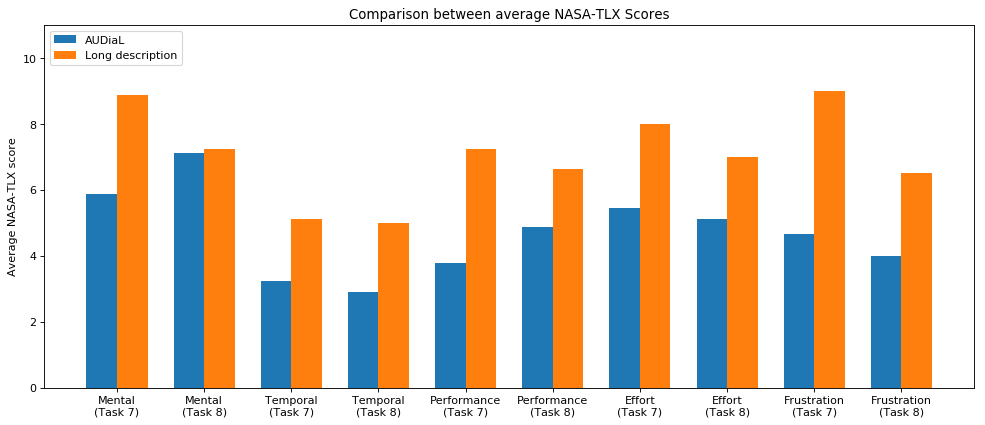

In [9]:
#  Collect statistics for each score of last two tasks in both modalities
tlx_names = ['Mental', 'Temporal', 'Performance', 'Effort', 'Frustration']
tlx_scores_dialogue = {}
tlx_scores_table = {}

ticks = ['Task {}'.format(i+1) for i in task_idx] * len(tlx_names)
i = 0
for t_n in tlx_names:
    tlx_scores_dialogue[t_n] = analyze_data('Dialogue__TLX__{}'.format(t_n), start=start)
    tlx_scores_table[t_n] = analyze_data('Table__TLX__{}'.format(t_n), start=start)
    ticks[i] = '{}\n({})'.format(t_n, ticks[i])
    ticks[i+1] = '{}\n({})'.format(t_n, ticks[i+1])
    i += 2

scores_avg = [[], []]
for t_n in tlx_names:
    scores_avg[0].extend(tlx_scores_dialogue[t_n][0])
    scores_avg[1].extend(tlx_scores_table[t_n][0])

fig = plt.figure(figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
width = 0.35
ind = np.arange(len(scores_avg[0]))

plt.bar(ind - width/2, scores_avg[0], width, label='AUDiaL')
plt.bar(ind + width/2, scores_avg[1], width, label='Long description')
plt.xticks(ind, ticks)
plt.ylim(0, 11)
plt.legend(loc='upper left')
plt.title('Comparison between average NASA-TLX Scores')
plt.ylabel('Average NASA-TLX score')
plt.show()

[]

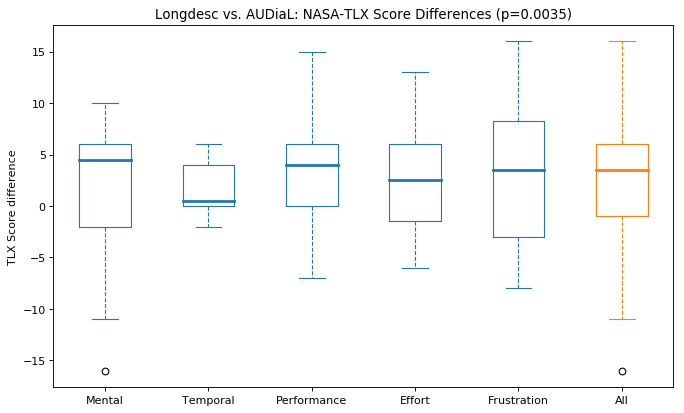

In [10]:
# Differences between individual NASA-TLX scores
tlx_count = len(tlx_names)
diffs = []
p_vals = []
end = start + 2
tlx_d_comb, tlx_t_comb = [], []
for t_n in tlx_names:
    diffs_tn = []
    for i in range(start, end):
        tlx_d = eval_data[:]['Dialogue__TLX__{}__{}'.format(t_n, i)]
        tlx_t = eval_data[:]['Table__TLX__{}__{}'.format(t_n, i)]
        for j in range(len(tlx_d)):
            if tlx_d[j] > -1 and tlx_t[j] > -1:
                diffs_tn.append(tlx_t[j] - tlx_d[j])
                tlx_d_comb.append(tlx_d[j])
                tlx_t_comb.append(tlx_t[j])
    diffs.append(diffs_tn)
diffs = np.array(diffs)
# T-test for the means of both populations
_, p_val = stats.ttest_ind(tlx_t_comb, tlx_d_comb)
# Plot statistics
fig = plt.figure(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
bp1 = plt.boxplot(diffs.T, positions=range(tlx_count), widths=.5)
set_box_color(bp1, '#1F77B4')
bp2 = plt.boxplot(diffs.flatten(), positions=[tlx_count], widths=.5)
set_box_color(bp2, '#FF7F0E')
plt.xticks(range(tlx_count + 1), tlx_names + ['All'])
plt.xlim(-0.5, tlx_count+0.5)
plt.title('Longdesc vs. AUDiaL: NASA-TLX Score Differences (p={:06.4f})'.format(p_val))
plt.ylabel('TLX Score difference')
plt.plot()

### System Usability Scale (SUS)

The System Usability Scale (SUS) has been the <i>de facto</i> standard for measuring perceived software usability for more than 25 years, having provided its value over time [[Brooke, 2013]](https://dl.acm.org/citation.cfm?id=2817913). SUS has been shown to produce the most reliable results among all sample sizes when compared to four other Website usability questionnaires [[Tullis et al. 2004]](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.396.3677). Moreover, it can be used on small sample sizes with reliable results, with a reported accuracy of 75% with a sample size of just 8. It consists of a questionnaire with 10 simple and quick to answer questions, each of which has one possible answer out of five options ranging from "Strongly Agree" (numerical value: 5) to "Strongly Disagree" (numerical value: 1). The ten questions are as follows:

<ol>
    <li>I think that I would like to use this system frequently</li>
    <li>I found the system unnecessarily complex</li>
    <li>I thought the system was easy to use</li>
    <li>I think that I would need the support of a technical person to be able to use this system</li>
    <li>I found the various functions in this system were well integrated</li>
    <li>I thought there was too much inconsistency in this system</li>
    <li>I would imagine that most people would learn to use this system very quickly</li>
    <li>I found the system very cumbersome to use</li>
    <li>I felt very confident using the system</li>
    <li>I needed to learn a lot of things before I could get going with this system</li>
</ol>

From the answers given to these questions, a final usability score (the SUS score) for each participant can be computed, ranging on a scale from 0 (extremely poor satisfaction) to 100 (extremely high satisfaction). The SUS score is computed by first summing up the score contributions from each item, where each answer is scored in the following manner:

* Odd items (1, 3, 5, 7, and 9) are scored by substracting 1 to their numerical value
* Even items (2, 4, 6, 8, and 10) are scored by substracting their numerical value to 5

Finally, the sum of these scores is multiplied by 2.5 to obtain the final SUS score for the given participant. SUS scores between 60 and 70 are considered average.

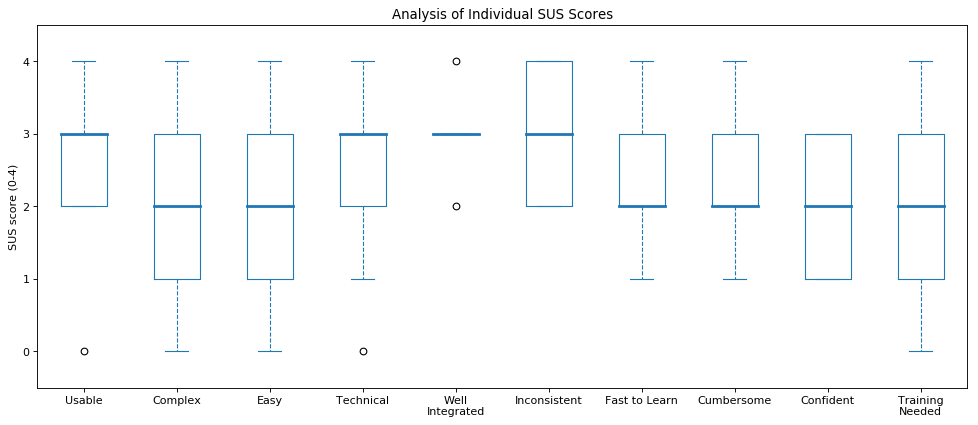

In [11]:
def sus_score(answer, idx):
    sus_values = {'Strongly Agree': 5, 'Agree': 4, 'Neutral': 3, 'Disagree': 2, 'Strongly Disagree': 1}
    return sus_values.get(answer, 1) - 1 if idx % 2 else 5 - sus_values.get(answer, 5)

# Plot average of individual SUS scores
fig = plt.figure(figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
sus_labels = ['Usable', 'Complex', 'Easy', 'Technical', 'Well\nIntegrated', 'Inconsistent', 
              'Fast to Learn', 'Cumbersome', 'Confident', 'Training\nNeeded']
x = range(len(sus_labels))
sus_scores_all = []
for i in range(1, 11):
    sus_answers = eval_data[:]['SUS{}'.format(i)]
    sus_values = [sus_score(a, i) for a in sus_answers]
    sus_scores_all.append(sus_values)
x = range(len(sus_labels))
bp = plt.boxplot(sus_scores_all, positions=x)
set_box_color(bp, '#1F77B4')
plt.xticks(x, sus_labels)
plt.ylim(-0.5, 4.5)
plt.title('Analysis of Individual SUS Scores')
plt.ylabel('SUS score (0-4)')
plt.show()

Average SUS score: 58.61


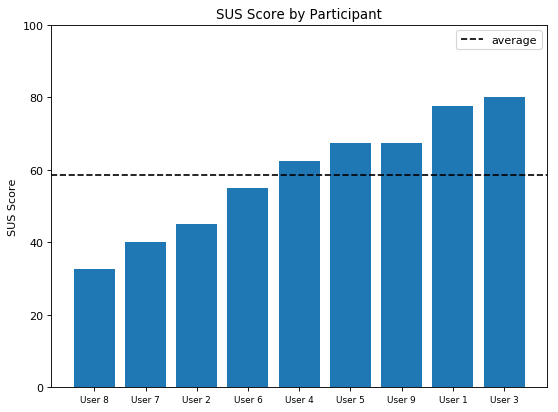

In [12]:
# Compute SUS score for each user and fetch usernames
sus_scores = np.sum(np.array(sus_scores_all), axis=0) * 2.5
usernames = np.array(['User {}'.format(i) for i in eval_data[:]['Name']])
# Compute SUS score average
sus_avg = np.mean(sus_scores)
print('Average SUS score: {:05.2f}'.format(sus_avg))
# Sort both arrays according to SUS score
idx_sort = sus_scores.argsort()
sus_sorted = sus_scores[idx_sort]
users_sorted = usernames[idx_sort]
# Plot all
fig = plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
x = range(len(usernames))
plt.bar(x, sus_sorted)
plt.axhline(y=sus_avg, color='k', linestyle='--', label='average')
plt.xticks(x, users_sorted)
plt.xticks(fontsize=8)
plt.ylim(0, 100)
plt.legend(loc='upper right')
plt.ylabel('SUS Score')
plt.title('SUS Score by Participant')
plt.show()